### Analysis and plotting of structural networks from Tractflow output

In [14]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def find_network_label(node, networks):
    '''
    find the network that appears the node's name
    node is a string containing a node's name
    networks is a list of networks names
    '''
    for network in networks:
        if network in node:
            return network
    return None

def segment_FC(FC, nodes, networks):
    '''
    average FC values over each large network in
    networks
    the output FC matrix will be in the same order as 
    networks
    '''
    segmented = np.zeros((len(networks), len(networks)))
    counts = np.zeros((len(networks), len(networks)))
    for i, node_i in enumerate(nodes):
        network_i = networks.index(find_network_label(node_i, networks))
        for j, node_j in enumerate(nodes):
            network_j = networks.index(find_network_label(node_j, networks))
            segmented[network_i, network_j] += FC[i, j]
            counts[network_i, network_j] += 1
    return np.divide(segmented, counts, out=np.zeros_like(segmented), where=counts!=0) 

In [3]:
dataset = "qpn"
current_release = "Jan_2024"
fmriprep_version = "v23.1.3"

# /home/nikhil/projects/Parkinsons/qpn/derivatives/freesurfer/v7.3.2/IDP/ses-01

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}"
tabular_dir = f"{release_dir}/tabular/"
derivatives_dir = f"{release_dir}/derivatives/"
proc_dir = f"{release_dir}/proc/"

# Current nipoppy manifest
manifest_csv = f"{tabular_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics/demographics.csv"

# fmriprep extractions
fmriprep_extract_dir = f"{derivatives_dir}/fmriprep/{fmriprep_version}/IDP/FC/output/"

# network defs
network_def_dir = f"{derivatives_dir}/networks/v1.5.0/"
# /home/nikhil/projects/Parkinsons/qpn/derivatives/fmriprep/v23.1.3/IDP/FC/output/sub-PD01759/ses-01

### Load data

In [4]:
visit = "MRI_v1"

demo_df = pd.read_csv(demographics_csv)
mri_demo_df = demo_df[demo_df["visit"]==visit]
participants = mri_demo_df["participant_id"].unique()
n_participants = len(participants)
print(f"Number of participants: {n_participants}")

print(mri_demo_df["group_at_screening"].value_counts())
PD_group = "PD   (Parkinson's Disease)/Maladie de Parkinson"
HC_group = "Healthy control/Contrôle"

PD_participants = list(mri_demo_df[mri_demo_df["group_at_screening"]==PD_group]["participant_id"].unique())
HC_participants = list(mri_demo_df[mri_demo_df["group_at_screening"]==HC_group]["participant_id"].unique())

print(f"Number of PD participants: {len(PD_participants)}")
print(f"Number of HC participants: {len(HC_participants)}")

mri_demo_df.head()

Number of participants: 286
group_at_screening
PD   (Parkinson's Disease)/Maladie de Parkinson                203
Healthy control/Contrôle                                        67
PPS (Parkinson Plus Syndrome)/PPS (Syndrome Parkinson Plus)     11
Name: count, dtype: int64
Number of PD participants: 203
Number of HC participants: 67


,participant_id,redcap_event_name,group_at_screening,sex,years_education_at_screening,duration_disease_at_screening,diagnosis_determined,assessment,visit_id,age,visit
0,MNI0028,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,18,3.5,PD,MRI,v1,60.19,MRI_v1
5,MNI0056,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,6,6.5,NaN,MRI,v1,79.24,MRI_v1
9,MNI0058,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,11,3.8,PD,MRI,v1,57.43,MRI_v1
13,MNI0068,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,M,12,10.2,PD,MRI,v1,69.30,MRI_v1
16,MNI0079,Baseline (Arm 1: C-OPN),PD (Parkinson's Disease)/Maladie de Parkinson,F,20+,6.8,PD,MRI,v1,50.08,MRI_v1


### Network defs

In [5]:
# Network regions
space = "MNI152NLin2009cAsym_res-2"
parcels = 100
atlas = "Schaefer2018"
desc = f"{parcels}Parcels7Networks"

network_regions = f"{network_def_dir}/atlas-{atlas}_desc-{desc}_dseg.tsv"

network_regions_df = pd.read_csv(network_regions, sep="\t")
print(f"network_regions_df.shape: {network_regions_df.shape}")
network_regions_df[["n_regions", "hemi", "network", "network_index"]] = network_regions_df["name"].str.split("_",n=3,expand=True)
network_regions_df.head()

network_regions_df.shape: (100, 3)


,index,name,color,n_regions,hemi,network,network_index
0,1,7Networks_LH_Vis_1,#781283,7Networks,LH,Vis,1
1,2,7Networks_LH_Vis_2,#781284,7Networks,LH,Vis,2
2,3,7Networks_LH_Vis_3,#781285,7Networks,LH,Vis,3
3,4,7Networks_LH_Vis_4,#781287,7Networks,LH,Vis,4
4,5,7Networks_LH_Vis_5,#781288,7Networks,LH,Vis,5


In [33]:
session = "ses-01"
metric = 'correlation' # correlation , covariance , precision 
YEO_networks = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont','Default']

# participant_id = "sub-PD00020"
PD_network_df_list = []
HC_network_df_list = []
missing_participants = []
for participant_id in PD_participants + HC_participants:
    bids_id = f"sub-{participant_id}"
    participant_FC_dir = f"{fmriprep_extract_dir}/sub-{participant_id}/{session}/"
    participant_FC_npy = f"{participant_FC_dir}/sub-{participant_id}_{session}_task-rest_space-{space}_FC_schaefer_{parcels}.npy"

    try:
        FC = np.load(participant_FC_npy, allow_pickle=True).item()
        roi_labels = FC['roi_labels']
        roi_labels = [str(label) for label in roi_labels]
        roi_labels = [label[label.find('Networks')+9:-3] for label in roi_labels]
        segmented_FC = segment_FC(FC[metric], nodes=roi_labels, networks=YEO_networks)
        FC_connectome = FC[metric]
        # network_df = pd.DataFrame(FC_connectome, columns=roi_labels, index=roi_labels)

    except FileNotFoundError:
        missing_participants.append(participant_id)
        print(f"File not found: {participant_FC_npy}")
        continue


    if participant_id in PD_participants:
        PD_network_df_list.append(FC_connectome)
    elif participant_id in HC_participants:
        HC_network_df_list.append(FC_connectome)
    else:
        print(f"Participant {participant_id} not in PD or HC group")
        
print(f"n missing participants: {len(missing_participants)}")
print(f"network list length: HC:{len(HC_network_df_list)}, PD:{len(PD_network_df_list)}")

File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0028/ses-01//sub-MNI0028_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy
File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0148/ses-01//sub-MNI0148_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy
File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0168/ses-01//sub-MNI0168_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy
File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0178/ses-01//sub-MNI0178_ses-01_task-rest_space-MNI152NLin2009cAsym_res-2_FC_schaefer_100.npy
File not found: /home/nikhil/projects/Parkinsons/qpn//releases/Jan_2024/derivatives//fmriprep/v23.1.3/IDP/FC/output//sub-MNI0245

In [39]:
missing_participants

['MNI0028',
 'MNI0148',
 'MNI0168',
 'MNI0178',
 'MNI0245',
 'MNI0249',
 'MNI0255',
 'MNI0259',
 'MNI0269',
 'MNI0280',
 'MNI0283',
 'MNI0296',
 'MNI0336',
 'MNI0339',
 'MNI0372',
 'MNI0375',
 'MNI0379',
 'MNI0383',
 'MNI0384',
 'MNI0397',
 'MNI0399',
 'MNI0402',
 'MNI0415',
 'MNI0428',
 'MNI0431',
 'MNI0439',
 'MNI0442',
 'MNI0443',
 'MNI0444',
 'MNI0448',
 'MNI0452',
 'MNI0455',
 'MNI0461',
 'MNI0465',
 'MNI0476',
 'MNI0528',
 'MNI0529',
 'MNI0546',
 'MNI0554',
 'MNI0555',
 'MNI0562',
 'MNI0564',
 'MNI0568',
 'MNI0571',
 'MNI0574',
 'MNI0587',
 'MNI0590',
 'MNI0607',
 'PD00457',
 'PD01268',
 'PD01340',
 'PD01500',
 'MNI0143',
 'MNI0144',
 'MNI0194',
 'MNI0200',
 'MNI0202',
 'MNI0206',
 'MNI0215',
 'MNI0216',
 'MNI0224',
 'MNI0301',
 'MNI0313',
 'MNI0320',
 'MNI0324',
 'MNI0326',
 'MNI0335',
 'MNI0350',
 'MNI0352',
 'MNI0353',
 'MNI0356',
 'MNI0359',
 'MNI0370',
 'MNI0371',
 'MNI0381',
 'MNI0388',
 'MNI0414',
 'MNI0416',
 'MNI0417',
 'MNI0419',
 'MNI0420',
 'MNI0421',
 'MNI0437',
 'MN

### Aggregate and thrshold group networks

In [34]:
threshold_network = "None" #"remove_outliers"

threshold_dict = { 
    "100Parcels7Networks" : {
        "binarize": 100,
        "lower_bound": 100,
        "upper_bound": 4000
    },
    "1000Parcels7Networks" : {
        "binarize": 10,
        "lower_bound": 2,
        "upper_bound": 50
    }
}

PD_network_df = np.stack(PD_network_df_list,axis=2).mean(axis=2)
HC_network_df = np.stack(HC_network_df_list,axis=2).mean(axis=2)

# sanity checks
PD_avg_connectivity = PD_network_df.mean()
HC_avg_connectivity = HC_network_df.mean()
print("-"*50)
print(f"PD_avg_connectivity: {PD_avg_connectivity}")
print(f"HC_avg_connectivity: {HC_avg_connectivity}")
print("-"*50)

if threshold_network == "binarize":
    print("Binarizing")
    thrshold = threshold_dict[desc]["binarize"]
    PD_network_df = (PD_network_df > thrshold).astype(int)
    HC_network_df = (HC_network_df > thrshold).astype(int)

elif threshold_network == "remove_outliers":
    print("Removing outliers")
    lower_bound = threshold_dict[desc]["lower_bound"]
    upper_bound = threshold_dict[desc]["upper_bound"]
    PD_network_df[(PD_network_df < lower_bound)] = 0
    PD_network_df[(PD_network_df > upper_bound)] = upper_bound
    HC_network_df[(HC_network_df < lower_bound)] = 0
    HC_network_df[(HC_network_df > upper_bound)] = upper_bound
else:
    print("No thresholding applied")

# sanity checks
PD_avg_connectivity = PD_network_df.mean()
HC_avg_connectivity = HC_network_df.mean()
print("-"*50)
print(f"PD_avg_connectivity: {PD_avg_connectivity}")
print(f"HC_avg_connectivity: {HC_avg_connectivity}")
print("-"*50)
print(f"PD_network_df.shape: {PD_network_df.shape}")
print(f"HC_network_df.shape: {HC_network_df.shape}")

--------------------------------------------------
PD_avg_connectivity: 0.20885351750798073
HC_avg_connectivity: 0.270733995709371
--------------------------------------------------
No thresholding applied
--------------------------------------------------
PD_avg_connectivity: 0.20885351750798073
HC_avg_connectivity: 0.270733995709371
--------------------------------------------------
PD_network_df.shape: (100, 100)
HC_network_df.shape: (100, 100)


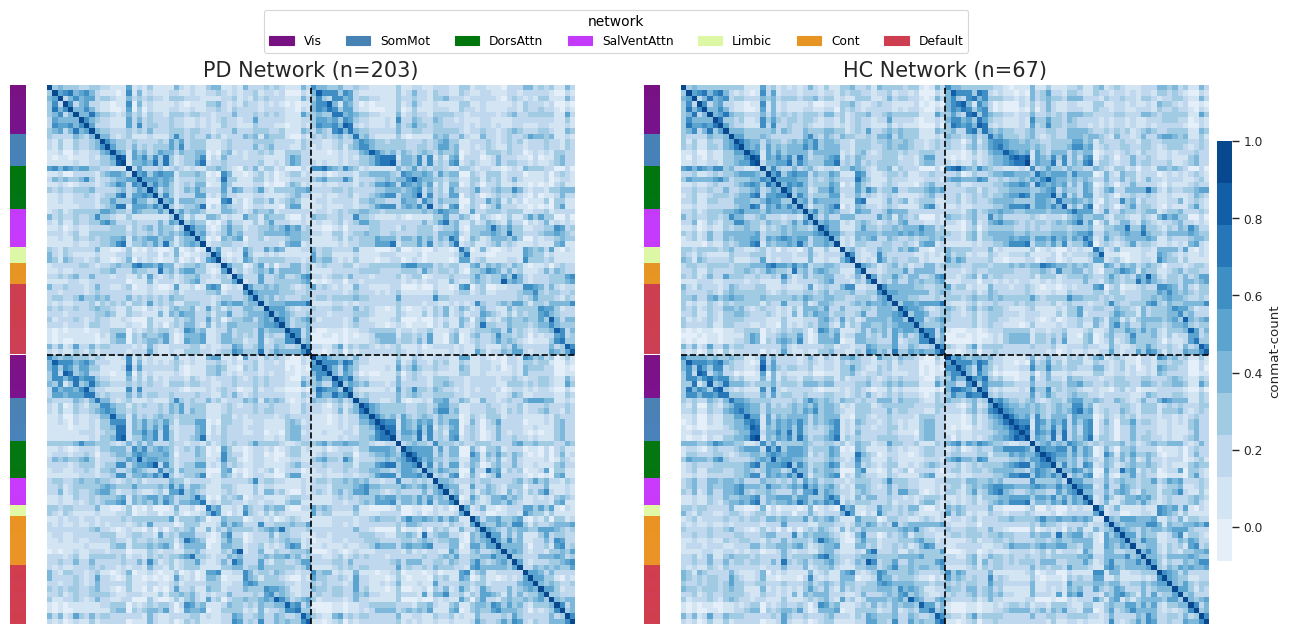

In [38]:
cmap = sns.color_palette("Blues",10) #"Greys"
row_colors = network_regions_df["color"]

legend_TN = [mpatches.Patch(color=c, label=l) for c,l in network_regions_df[['color','network']].drop_duplicates("network").values]
midline_idx = PD_network_df.shape[0]//2

with sns.axes_style("white"):
    sns.set_context("paper")
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15, 7))
    cbar_ax = fig.add_axes([.905, .2, .01, .6])

    # -------------------------------------------------------------------------------------#
    # PD
    # -------------------------------------------------------------------------------------#
    plot_df = PD_network_df.copy()
    ax = axes[0]
    g = sns.heatmap(plot_df, square=False, xticklabels=False, yticklabels=False, cmap=cmap, ax=ax, cbar=False) #cbar_kws={"shrink": .5}
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    ax.set_title(f"PD Network (n={len(PD_participants)})",fontsize=15)
    ax.axhline(y=midline_idx, color='k', linestyle='--')
    ax.axvline(x=midline_idx, color='k', linestyle='--')
   
    for i, color in enumerate(row_colors):
        g.add_patch(plt.Rectangle(xy=(-0.07, i), width=0.03, height=1, color=color, lw=0,
                                transform=g.get_yaxis_transform(), clip_on=False))

    # -------------------------------------------------------------------------------------#
    # HC
    # -------------------------------------------------------------------------------------#
    plot_df = HC_network_df.copy()
    ax = axes[1]
    g = sns.heatmap(plot_df, square=False, xticklabels=False, yticklabels=False, cmap=cmap, ax=ax, 
                    cbar_kws= {'label': 'conmat-count'},cbar_ax=cbar_ax) #cbar_kws={"shrink": .5}
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    ax.set_title(f"HC Network (n={len(HC_participants)})",fontsize=15)
    ax.axhline(y=midline_idx, color='k', linestyle='--')
    ax.axvline(x=midline_idx, color='k', linestyle='--')

    for i, color in enumerate(row_colors):
        g.add_patch(plt.Rectangle(xy=(-0.07, i), width=0.03, height=1, color=color, lw=0,
                                transform=g.get_yaxis_transform(), clip_on=False))
    
l2=g.legend(loc='center left',bbox_to_anchor=(-0.8,1.1),ncol=7, handles=legend_TN,frameon=True) #(1.01,0.9)
l2.set_title(title='network',prop={'size':10})
# plt.tight_layout()